In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('../generated_cpu_data_with_anomaly_v2_custom_threshold_v2.csv')
df['date'] = pd.to_datetime(df['date'])

In [3]:
df

,cpu_util,date,anomaly
0,89.447320,2023-06-25 00:03:05.640,1
1,57.320538,2023-06-25 00:08:05.640,0
2,87.058688,2023-06-25 00:13:05.640,1
3,87.409467,2023-06-25 00:18:05.640,1
4,78.111494,2023-06-25 00:23:05.640,0
...,...,...,...
8635,2.692620,2023-07-24 23:38:06.441,0
8636,30.604348,2023-07-24 23:43:06.441,0
8637,14.278655,2023-07-24 23:48:06.441,0
8638,35.247145,2023-07-24 23:53:06.441,0


In [4]:
num_lags = 2

#add lag
for i in range(1, num_lags+1):
    df['lag_{}'.format(i)] = df['cpu_util'].shift(i)
  
df = df.dropna()

In [5]:
df

,cpu_util,date,anomaly,lag_1,lag_2
2,87.058688,2023-06-25 00:13:05.640,1,57.320538,89.447320
3,87.409467,2023-06-25 00:18:05.640,1,87.058688,57.320538
4,78.111494,2023-06-25 00:23:05.640,0,87.409467,87.058688
5,65.111306,2023-06-25 00:28:05.640,0,78.111494,87.409467
6,94.526610,2023-06-25 00:33:05.640,1,65.111306,78.111494
...,...,...,...,...,...
8635,2.692620,2023-07-24 23:38:06.441,0,16.306464,30.297529
8636,30.604348,2023-07-24 23:43:06.441,0,2.692620,16.306464
8637,14.278655,2023-07-24 23:48:06.441,0,30.604348,2.692620
8638,35.247145,2023-07-24 23:53:06.441,0,14.278655,30.604348


In [6]:
X = df[['cpu_util', 'lag_1', 'lag_2']]
y = df['anomaly']

In [7]:
X['cpu_util'] = (X['cpu_util']/100).astype(float)
X['lag_1'] = (X['lag_1']/100).astype(float)
X['lag_2'] = (X['lag_2']/100).astype(float)

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3277832909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cpu_util'] = (X['cpu_util']/100).astype(float)
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3277832909.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['lag_1'] = (X['lag_1']/100).astype(float)
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3277832909.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [8]:
X_train = X[:int(0.7*len(X))]
X_test = X[int(0.7*len(X)):]
y_train = y[:int(0.7*len(y))]
y_test = y[int(0.7*len(y)):]

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3789776307.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_train = y[:int(0.7*len(y))]
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3789776307.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  y_test = y[int(0.7*len(y)):]


In [9]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(3, 1), return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20


189/189 [==============================] - 7s 13ms/step - loss: 0.4558 - accuracy: 0.8344 - val_loss: 0.2189 - val_accuracy: 0.9209
Epoch 2/20
189/189 [==============================] - 1s 8ms/step - loss: 0.2993 - accuracy: 0.8970 - val_loss: 0.2051 - val_accuracy: 0.9483
Epoch 3/20
189/189 [==============================] - 1s 8ms/step - loss: 0.2489 - accuracy: 0.9204 - val_loss: 0.1858 - val_accuracy: 0.9498
Epoch 4/20
189/189 [==============================] - 1s 8ms/step - loss: 0.2259 - accuracy: 0.9300 - val_loss: 0.1769 - val_accuracy: 0.9502
Epoch 5/20
189/189 [==============================] - 2s 8ms/step - loss: 0.2096 - accuracy: 0.9319 - val_loss: 0.1766 - val_accuracy: 0.9456
Epoch 6/20
189/189 [==============================] - 2s 9ms/step - loss: 0.2056 - accuracy: 0.9327 - val_loss: 0.1584 - val_accuracy: 0.9510
Epoch 7/20
189/189 [==============================] - 1s 8ms/step - loss: 0.1955 - accuracy: 0.9338 - val_loss: 0.1474 - val_accuracy: 0.9510
Epo

In [12]:
model.evaluate(X_test, y_test)

81/81 [==============================] - 0s 3ms/step - loss: 0.0732 - accuracy: 0.9715


[0.0732063502073288, 0.9714506268501282]

In [48]:
model.predict([
  [0.53, 0.53, 0.20],
  [0.48, 0.53, 0.53],
  [0.60, 0.48, 0.53],
  [0.53, 0.60, 0.48],
  [0.24, 0.53, 0.60],
  [0.83, 0.24, 0.53],
  [0.24, 0.83, 0.24],
  [0.45, 0.24, 0.83],
  [1, 1, 1]
])

1/1 [==============================] - 0s 91ms/step


array([[2.2410852e-01],
       [3.6343855e-03],
       [2.2277570e-01],
       [1.1540730e-02],
       [3.0495976e-05],
       [6.0479754e-01],
       [2.9320625e-05],
       [1.6970201e-03],
       [9.9961472e-01]], dtype=float32)

In [23]:
[[2.2410852e-01],
       [3.6343855e-03],
       [2.2277570e-01],
       [1.1540730e-02],
       [3.0495974e-05],
       [6.0479754e-01],
       [2.9320625e-05]]

[[0.22410852],
 [0.0036343855],
 [0.2227757],
 [0.01154073],
 [3.0495974e-05],
 [0.60479754],
 [2.9320625e-05]]

In [26]:
df_test = pd.read_csv('../generated_cpu_data_test_2.csv')
df_test['date'] = pd.to_datetime(df_test['date'])

In [29]:
num_lags = 2

#add lag
for i in range(1, num_lags+1):
    df_test['lag_{}'.format(i)] = df_test['cpu_util'].shift(i)
  
df_test = df_test.dropna()

In [30]:
df_test

,cpu_util,date,lag_1,lag_2
2,100.895190,2023-07-25 00:13:06.466,82.067813,66.834766
3,73.259342,2023-07-25 00:18:06.466,100.895190,82.067813
4,82.504274,2023-07-25 00:23:06.466,73.259342,100.895190
5,62.700953,2023-07-25 00:28:06.466,82.504274,73.259342
6,88.266038,2023-07-25 00:33:06.466,62.700953,82.504274
...,...,...,...,...
10363,28.858958,2023-08-29 23:38:07.394,31.093691,53.711871
10364,23.238560,2023-08-29 23:43:07.394,28.858958,31.093691
10365,53.869919,2023-08-29 23:48:07.394,23.238560,28.858958
10366,30.824553,2023-08-29 23:53:07.394,53.869919,23.238560


In [31]:
X_test = df_test[['cpu_util', 'lag_1', 'lag_2']]

In [32]:
X_test['cpu_util'] = (X_test['cpu_util']/100).astype(float)
X_test['lag_1'] = (X_test['lag_1']/100).astype(float)
X_test['lag_2'] = (X_test['lag_2']/100).astype(float)

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\1668866457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['cpu_util'] = (X_test['cpu_util']/100).astype(float)
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\1668866457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['lag_1'] = (X_test['lag_1']/100).astype(float)
C:\Users\HP\AppData\Local\Temp\ipykernel_11772\1668866457.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_ind

In [35]:
predict = model.predict(X_test)

324/324 [==============================] - 2s 4ms/step


In [36]:
predict

array([[9.9825251e-01],
       [3.1287852e-04],
       [6.1251987e-03],
       ...,
       [5.8365941e-01],
       [6.2511201e-05],
       [1.8151065e-04]], dtype=float32)

In [37]:
#add the prediction to the test data
df_test['predict'] = predict


C:\Users\HP\AppData\Local\Temp\ipykernel_11772\3300978574.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = predict


In [38]:
df_test['predict'] = df_test['predict'].apply(lambda x: 1 if x > 0.5 else 0)

C:\Users\HP\AppData\Local\Temp\ipykernel_11772\1053937000.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['predict'] = df_test['predict'].apply(lambda x: 1 if x > 0.5 else 0)


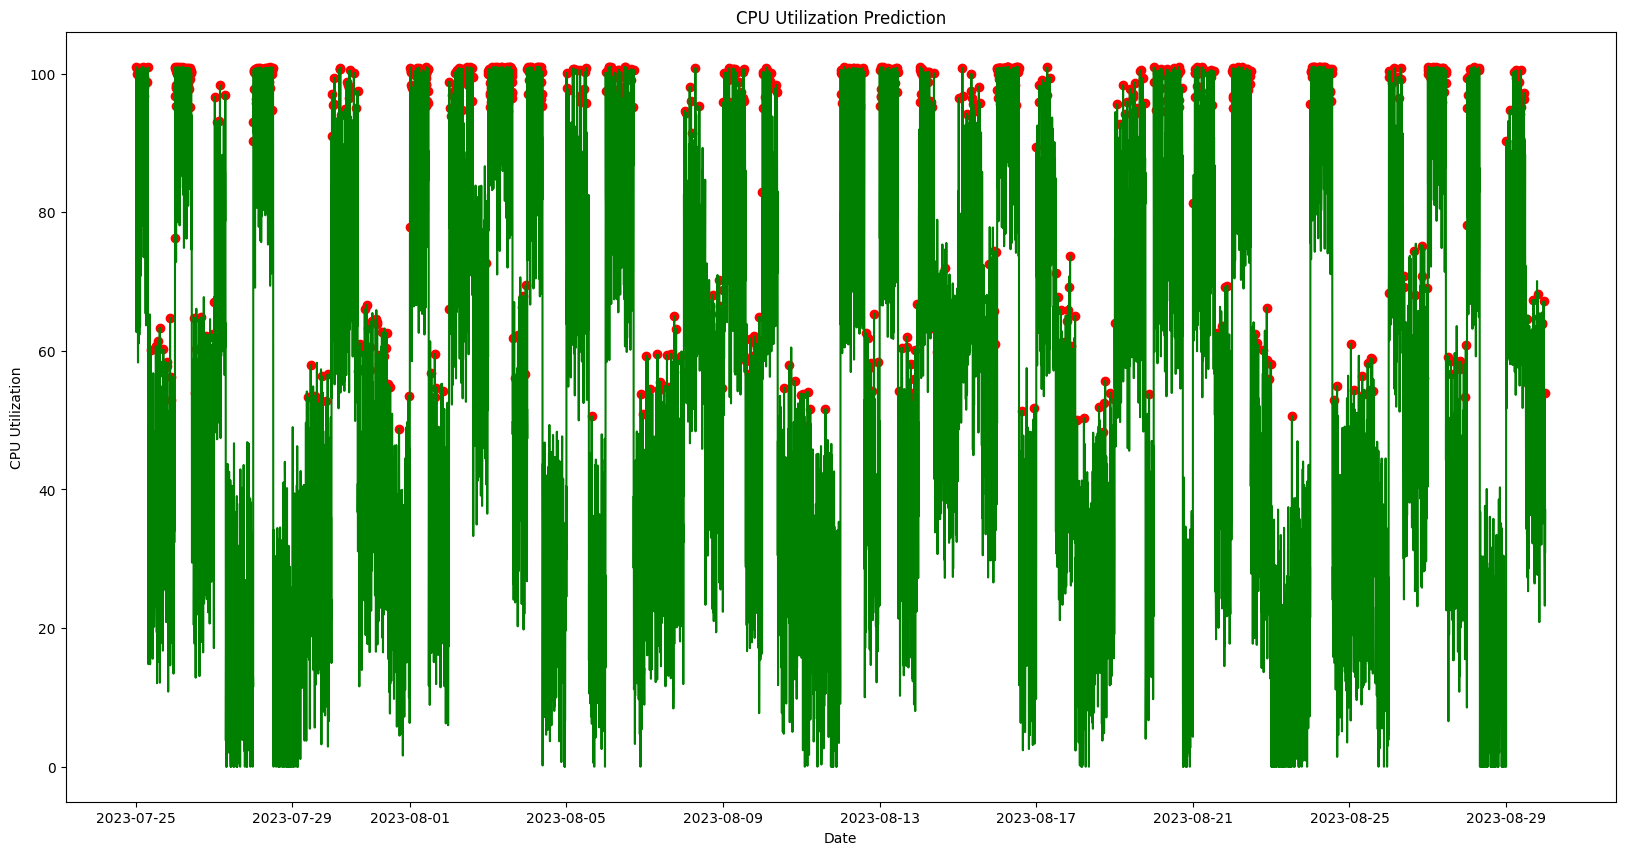

In [46]:
#scatter plot the prediction 1
anomaly = df_test.iloc[np.where(df_test['predict'] == 1)]

plt.figure(figsize=(20,10))
plt.plot(df_test['date'], df_test['cpu_util'], color='green')
plt.scatter(anomaly['date'], anomaly['cpu_util'], color='red')
plt.xlabel('Date')
plt.ylabel('CPU Utilization')
# plt.xlim(pd.Timestamp('2023-08-27'), pd.Timestamp('2023-08-28'))
plt.title('CPU Utilization Prediction')
plt.show()



In [47]:
model.save('model_custom_threshold.h5')

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
